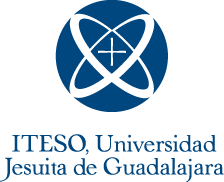

## Tarea 11: PYOMO
# Zurisadai Velazquez Manzanero
# Juan Mario Ochoa Navarro

# The Diet Problem

## Summary
The goal of the Diet Problem is to select foods that satisfy daily nutritional requirements at minimum cost. This problem can be formulated as a linear program, for which constraints limit the number of calories and the amount of vitamins, minerals, fats, sodium, and cholesterol in the diet. Danzig (1990) notes that the diet problem was motivated by the US Army's desire to minimize the cost of feeding GIs in the field while still providing a healthy diet.

## Problem Statement
The Diet Problem can be formulated mathematically as a linear programming problem using the following model.

## Sets
F = set of foods
N = set of nutrients

## Parameters
ci = cost per serving of food i, ∀i∈F

aij = amount of nutrient j in food i, ∀i∈F,∀j∈N

Nminj = minimum level of nutrient j, ∀j∈N

Nmaxj = maximum level of nutrient j, ∀j∈N

Vi = the volume per serving of food i, ∀i∈F

Vmax = maximum volume of food consumed

## Variables
xi = number of servings of food i to consume

## Objective
Minimize the total cost of the food
min∑i∈Fcixi
## Constraints
Limit nutrient consumption for each nutrient j∈N.

Nminj≤∑i∈Faijxi≤Nmaxj, ∀j∈N

Limit the volume of food consumed

∑i∈FVixi≤Vmax

Consumption lower bound

xi≥0, ∀i∈F

## Pyomo Formulation
We begin by importing the Pyomo package and creating a model object:

# Sección nueva



> Eingerückter The sets F and N are declared abstractly using the Set component:



In [ ]:
# Foods
model.F = Set()
# Nutrients
model.N = Set()

Similarly, the model parameters are defined abstractly using the Param component:


In [ ]:
# Cost of each food
model.c    = Param(model.F, within=PositiveReals)
# Amount of nutrient in each food
model.a    = Param(model.F, model.N, within=NonNegativeReals)
# Lower and upper bound on each nutrient
model.Nmin = Param(model.N, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.N, within=NonNegativeReals, default=infinity)
# Volume per serving of food
model.V    = Param(model.F, within=PositiveReals)
# Maximum volume of food consumed
model.Vmax = Param(within=PositiveReals)

The within option is used in these parameter declarations to define expected properties of the parameters. This information is used to perform error checks on the data that is used to initialize the parameter components.

The Var component is used to define the decision variables:

In [ ]:

# Number of servings consumed of each food
model.x = Var(model.F, within=NonNegativeIntegers)

The within option is used to restrict the domain of the decision variables to the non-negative reals. This eliminates the need for explicit bound constraints for variables.

The Objective component is used to define the cost objective. This component uses a rule function to construct the objective expression:

In [ ]:
# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.F)
model.cost = Objective(rule=cost_rule)

Similarly, rule functions are used to define constraint expressions in the Constraint component:



In [ ]:
# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.a[i,j]*model.x[i] for i in model.F)
    return inequality(model.Nmin[j], value, model.Nmax[j])
model.nutrient_limit = Constraint(model.N, rule=nutrient_rule)

# Limit the volume of food consumed
def volume_rule(model):
    return sum(model.V[i]*model.x[i] for i in model.F) <= model.Vmax
model.volume = Constraint(rule=volume_rule)

Putting these declarations all together gives the following model:



In [ ]:
!cat diet.py

from pyomo.environ import *
infinity = float('inf')

model = AbstractModel()

# Foods
model.F = Set()
# Nutrients
model.N = Set()

# Cost of each food
model.c    = Param(model.F, within=PositiveReals)
# Amount of nutrient in each food
model.a    = Param(model.F, model.N, within=NonNegativeReals)
# Lower and upper bound on each nutrient
model.Nmin = Param(model.N, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.N, within=NonNegativeReals, default=infinity)
# Volume per serving of food
model.V    = Param(model.F, within=PositiveReals)
# Maximum volume of food consumed
model.Vmax = Param(within=PositiveReals)

# Number of servings consumed of each food
model.x = Var(model.F, within=NonNegativeIntegers)

# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.F)
model.cost = Objective(rule=cost_rule)

# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.a[i,j]*model.x[

## Model Data

Since this is an abstract Pyomo model, the set and parameter values need to be provided to initialize the model. The following data command file provides a synthetic data set:

In [ ]:
!cat diet.dat


cat: diet.dat: No such file or directory


Set data is defined with the set command, and parameter data is defined with the param command.

This data set considers the problem of designing a daily diet with only food from a fast food chain.

## Solution
Pyomo includes a pyomo command that automates the construction and optimization of models. The GLPK solver can be used in this simple example:

In [ ]:
!pyomo solve --solver=glpk diet.py diet.dat


[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.00] Pyomo Finished
ERROR: Unexpected exception while running model:
        File diet.py does not exist!


In [ ]:
!cat results.yml


cat: results.yml: No such file or directory


## Max Flow

# Summary
The goal of the maximum flow problem is to find the maximum flow possible in a network from some given source node to a given sink node. Applications of the max flow problem include finding the maximum flow of orders through a job shop, the maximum flow of water through a storm sewer system, and the maximum flow of product through a product distribution system, among others. Schrijver (2002) note that the maximum flow problem was first formulated in 1954 by T. E. Harris and F. S. Ross as a simplified model of Soviet railway traffic flow.

A network is a directed graph, and the arc capacities, or upper bounds, are the only relevant parameters. A network graph does not have to be symmetric: if an arc (v,w) is in the graph, the reverse arc (w,v) does not have to be in the graph. Further, parallel arcs are not allowed, and self-loops are not allowed. The source and the sink are distinct nodes in the network, but the sink may be unreachable from the source.

## Problem Statement
The max flow problem can be formulated mathematically as a linear programming problem using the following model.

## Sets
N = nodes in the network
A = network arcs

## Parameters
s = source node
t = sink node
cij = arc flow capacity, ∀(i,j)∈A
## Variables
fi,j = arc flow, ∀(i,j)∈A
## Objective
Maximize the flow into the sink nodes
max∑{i∣(i,t)∈A}ci,tfi,t
## Constraints
Enforce an upper limit on the flow across each arc
fi,j≤ci,j, ∀(i,j)∈A
Enforce flow through each node
∑{i∣(i,j)∈A}fi,j=∑{i∣(j,i)∈A}fj,i, ∀j∈N−{s,t}
Flow lower bound
fi,j≥0, ∀(i,j)∈A
## Pyomo Formulation
We begin by importing the Pyomo package and creating a model object:

In [ ]:
from pyomo.environ import *

model = AbstractModel()

The sets N and A are declared abstractly using the Set component:

In [ ]:
# Nodes in the network
model.N = Set()
# Network arcs
model.A = Set(within=model.N*model.N)

Similarly, the model parameters are defined abstractly using the Param component:



In [ ]:
# Source node
model.s = Param(within=model.N)
# Sink node
model.t = Param(within=model.N)
# Flow capacity limits
model.c = Param(model.A)

The within option is used in these parameter declarations to define expected properties of the parameters. This information is used to perform error checks on the data that is used to initialize the parameter components.

The Var component is used to define the decision variables:

In [ ]:
# The flow over each arc
model.f = Var(model.A, within=NonNegativeReals)

The within option is used to restrict the domain of the decision variables to the non-negative reals. This eliminates the need for explicit bound constraints for variables.

The Objective component is used to define the cost objective. This component uses a rule function to construct the objective expression:

In [ ]:
# Maximize the flow into the sink nodes
def total_rule(model):
    return sum(model.f[i,j] for (i, j) in model.A if j == value(model.t))
model.total = Objective(rule=total_rule, sense=maximize)

Similarly, rule functions are used to define constraint expressions in the Constraint component:




In [ ]:
# Enforce an upper limit on the flow across each arc
def limit_rule(model, i, j):
    return model.f[i,j] <= model.c[i, j]
model.limit = Constraint(model.A, rule=limit_rule)

# Enforce flow through each node
def flow_rule(model, k):
    if k == value(model.s) or k == value(model.t):
        return Constraint.Skip
    inFlow  = sum(model.f[i,j] for (i,j) in model.A if j == k)
    outFlow = sum(model.f[i,j] for (i,j) in model.A if i == k)
    return inFlow == outFlow
model.flow = Constraint(model.N, rule=flow_rule)

Putting these declarations all together gives the following model:



In [36]:
!cat maxflow.py


from pyomo.environ import *

model = AbstractModel()

# Nodes in the network
model.N = Set()
# Network arcs
model.A = Set(within=model.N*model.N)

# Source node
model.s = Param(within=model.N)
# Sink node
model.t = Param(within=model.N)
# Flow capacity limits
model.c = Param(model.A)

# The flow over each arc
model.f = Var(model.A, within=NonNegativeReals)

# Maximize the flow into the sink nodes
def total_rule(model):
    return sum(model.f[i,j] for (i, j) in model.A if j == value(model.t))
model.total = Objective(rule=total_rule, sense=maximize)

# Enforce an upper limit on the flow across each arc
def limit_rule(model, i, j):
    return model.f[i,j] <= model.c[i, j]
model.limit = Constraint(model.A, rule=limit_rule)

# Enforce flow through each node
def flow_rule(model, k):
    if k == value(model.s) or k == value(model.t):
        return Constraint.Skip
    inFlow  = sum(model.f[i,j] for (i,j) in model.A if j == k)
    outFlow = sum(model.f[i,j] for (i,j) in model.A if i == k)
    

//////////////////////////////////////////////////////////////////////////////////////

## The p-Median Problem
# Summary
The goal of the p-median problem is to locating p facilities to minimize the demand weighted average distance between demand nodes and the nearest of the selected facilities. Hakimi (1964, 1965) first considered this problem for the design of network switch centers. However, this problem has been used to model a wide range of applications, such as warehouse location, depot location, school districting and sensor placement.

# Problem Statement
The p-median problem can be formulated mathematically as an integer programming problem using the following model.

# Sets
M = set of candidate locations
N = set of customer demand nodes

# Parameters
p = number of facilities to locate
dj = demand of customer j, ∀j∈N
cij = unit cost of satisfying customer j from facility i, ∀i∈M,∀j∈N
# Variables
xij = fraction of the demand of customer j that is supplied by facility i, ∀i∈M,∀j∈N
yi = a binary value that is 1 is a facility is located at location i, ∀i∈M
# Objective
Minimize the demand-weighted total cost
min∑i∈M∑j∈Ndjcijxij
# Constraints
All of the demand for customer j must be satisfied
∑i∈Mxij=1, ∀j∈N
Exactly p facilities are located
∑i∈Myi=p
Demand nodes can only be assigned to open facilities
xij≤yi, ∀i∈M,∀j∈N
The assignment variables must be non-negative
xij≥0, ∀i∈M,∀j∈N
# Pyomo Formulation
The following is an abstract Pyomo model for this problem:

In [37]:
!cat p-median.py


from pyomo.environ import *
import random

random.seed(1000)

model = AbstractModel()

# Number of candidate locations
model.m = Param(within=PositiveIntegers)
# Number of customers
model.n = Param(within=PositiveIntegers)
# Set of candidate locations
model.M = RangeSet(1,model.m)
# Set of customer nodes
model.N = RangeSet(1,model.n)

# Number of facilities
model.p = Param(within=RangeSet(1,model.n))
# d[j] - demand of customer j
model.d = Param(model.N, default=1.0)
# c[i,j] - unit cost of satisfying customer j from facility i
model.c = Param(model.M, model.N, initialize=lambda i, j, model : random.uniform(1.0,2.0), within=Reals)

# x[i,j] - fraction of the demand of customer j that is supplied by facility i
model.x = Var(model.M, model.N, bounds=(0.0,1.0))
# y[i] - a binary value that is 1 is a facility is located at location i
model.y = Var(model.M, within=Binary)

# Minimize the demand-weighted total cost
def cost_(model):
    return sum(model.d[j]*model.c[i,j]*model.x[i,j] for i i

//////////////////////////////////////////////////////////////

# The Transport Problem
# Summary
The goal of the Transport Problem is to select the quantities of an homogeneous good that has several production plants and several punctiform markets as to minimise the transportation costs.

It is the default tutorial for the GAMS language, and GAMS equivalent code is inserted as single-dash comments. The original GAMS code needs slighly different ordering of the commands and it's available at http://www.gams.com/mccarl/trnsport.gms.

# Problem Statement
The Transport Problem can be formulated mathematically as a linear programming problem using the following model.

# Sets
I = set of canning plants
J = set of markets

# Parameters
ai = capacity of plant i in cases, ∀i∈I
bj = demand at market j in cases, ∀j∈J
di,j = distance in thousands of miles, ∀i∈I,∀j∈J
f = freight in dollars per case per thousand miles
ci,j = transport cost in thousands of dollars per case

ci,j is obtained exougenously to the optimisation problem as ci,j=f⋅di,j, ∀i∈I,∀j∈J
# Variables
xi,j = shipment quantities in cases
z = total transportation costs in thousands of dollars

# Obective
Minimize the total cost of the shipments:
minxz=∑i∈I∑j∈Jci,jxi,j
# Constraints
Observe supply limit at plant i:
∑j∈Jxi,j≤ai, ∀i∈I
Satisfy demand at market j:
∑i∈Ixi,j≥bj, ∀j∈J
Non-negative transportation quantities
xi,j≥0, ∀i∈I,∀j∈J
# Pyomo Formulation
Creation of the Model
In pyomo everything is an object. The various components of the model (sets, parameters, variables, constraints, objective..) are all attributes of the main model object while being objects themselves.

There are two type of models in pyomo: A ConcreteModel is one where all the data is defined at the model creation. We are going to use this type of model in this tutorial. Pyomo however supports also an AbstractModel, where the model structure is firstly generated and then particular instances of the model are generated with a particular set of data.

The first thing to do in the script is to load the pyomo library and create a new ConcreteModel object. We have little imagination here, and we call our model "model". You can give it whatever name you want. However, if you give your model an other name, you also need to create a model object at the end of your script:

In [38]:
# Import of the pyomo module
from pyomo.environ import *
 
# Creation of a Concrete Model
model = ConcreteModel()

# Set Definitions
Sets are created as attributes object of the main model objects and all the information is given as parameter in the constructor function. Specifically, we are passing to the constructor the initial elements of the set and a documentation string to keep track on what our set represents:

In [39]:
## Define sets ##
#  Sets
#       i   canning plants   / seattle, san-diego /
#       j   markets          / new-york, chicago, topeka / ;
model.i = Set(initialize=['seattle','san-diego'], doc='Canning plans')
model.j = Set(initialize=['new-york','chicago', 'topeka'], doc='Markets')

# Parameters
Parameter objects are created specifying the sets over which they are defined and are initialised with either a python dictionary or a scalar:

In [40]:
## Define parameters ##
#   Parameters
#       a(i)  capacity of plant i in cases
#         /    seattle     350
#              san-diego   600  /
#       b(j)  demand at market j in cases
#         /    new-york    325
#              chicago     300
#              topeka      275  / ;
model.a = Param(model.i, initialize={'seattle':350,'san-diego':600}, doc='Capacity of plant i in cases')
model.b = Param(model.j, initialize={'new-york':325,'chicago':300,'topeka':275}, doc='Demand at market j in cases')
#  Table d(i,j)  distance in thousands of miles
#                    new-york       chicago      topeka
#      seattle          2.5           1.7          1.8
#      san-diego        2.5           1.8          1.4  ;
dtab = {
    ('seattle',  'new-york') : 2.5,
    ('seattle',  'chicago')  : 1.7,
    ('seattle',  'topeka')   : 1.8,
    ('san-diego','new-york') : 2.5,
    ('san-diego','chicago')  : 1.8,
    ('san-diego','topeka')   : 1.4,
    }
model.d = Param(model.i, model.j, initialize=dtab, doc='Distance in thousands of miles')
#  Scalar f  freight in dollars per case per thousand miles  /90/ ;
model.f = Param(initialize=90, doc='Freight in dollars per case per thousand miles')

A third, powerful way to initialize a parameter is using a user-defined function.

This function will be automatically called by pyomo with any possible (i,j) set. In this case pyomo will actually call c_init() six times in order to initialize the model.c parameter.

In [41]:
#  Parameter c(i,j)  transport cost in thousands of dollars per case ;
#            c(i,j) = f * d(i,j) / 1000 ;
def c_init(model, i, j):
  return model.f * model.d[i,j] / 1000
model.c = Param(model.i, model.j, initialize=c_init, doc='Transport cost in thousands of dollar per case')

# Variables
Similar to parameters, variables are created specifying their domain(s). For variables we can also specify the upper/lower bounds in the constructor.

Differently from GAMS, we don't need to define the variable that is on the left hand side of the objective function.

In [42]:
## Define variables ##
#  Variables
#       x(i,j)  shipment quantities in cases
#       z       total transportation costs in thousands of dollars ;
#  Positive Variable x ;
model.x = Var(model.i, model.j, bounds=(0.0,None), doc='Shipment quantities in case')

# Constrains
At this point, it should not be a surprise that constrains are again defined as model objects with the required information passed as parameter in the constructor function.

In [43]:
## Define contrains ##
# supply(i)   observe supply limit at plant i
# supply(i) .. sum (j, x(i,j)) =l= a(i)
def supply_rule(model, i):
  return sum(model.x[i,j] for j in model.j) <= model.a[i]
model.supply = Constraint(model.i, rule=supply_rule, doc='Observe supply limit at plant i')
# demand(j)   satisfy demand at market j ;  
# demand(j) .. sum(i, x(i,j)) =g= b(j);
def demand_rule(model, j):
  return sum(model.x[i,j] for i in model.i) >= model.b[j]  
model.demand = Constraint(model.j, rule=demand_rule, doc='Satisfy demand at market j')

The above code take advantage of list comprehensions, a powerful feature of the python language that provides a concise way to loop over a list. If we take the supply_rule as example, this is actually called two times by pyomo (once for each of the elements of i). Without list comprehensions we would have had to write our function using a for loop, like:

In [44]:
def supply_rule(model, i):
  supply = 0.0
  for j in model.j:
    supply += model.x[i,j]
  return supply <= model.a[i]

Using list comprehension is however quicker to code and more readable.

# Objective and Solving
The definition of the objective is similar to those of the constrains, except that most solvers require a scalar objective function, hence a unique function, and we can specify the sense (direction) of the optimisation.

In [45]:
## Define Objective and solve ##
#  cost        define objective function
#  cost ..        z  =e=  sum((i,j), c(i,j)*x(i,j)) ;
#  Model transport /all/ ;
#  Solve transport using lp minimizing z ;
def objective_rule(model):
  return sum(model.c[i,j]*model.x[i,j] for i in model.i for j in model.j)
model.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')

As we are here looping over two distinct sets, we can see how list comprehension really simplifies the code. The objective function could have being written without list comprehension as:

In [46]:
def objective_rule(model):
  obj = 0.0  
  for ki in model.i:
    for kj in model.j:
      obj += model.c[ki,kj]*model.x[ki,kj]
  return obj

# Retrieving the Output
We use the pyomo_postprocess() function to retrieve the output and do something with it. For example, we could display solution values (see below), plot a graph with matplotlib or save it in a csv file.

This function is called by pyomo after the solver has finished.

In [47]:
## Display of the output ##
# Display x.l, x.m ;
def pyomo_postprocess(options=None, instance=None, results=None):
  model.x.display()

We can print model structure information with model.pprint() (“pprint” stand for “pretty print”). Results are also by default saved in a results.json file or, if PyYAML is installed in the system, in results.yml.

# Editing and Running the Script
Differently from GAMS, you can use whatever editor environment you wish to code a pyomo script. If you don't need debugging features, a simple text editor like Notepad++ (in windows), gedit or kate (in Linux) will suffice. They already have syntax highlight for python.

If you want advanced features and debugging capabilities you can use a dedicated Python IDE, like e.g. Spyder.

You will normally run the script as pyomo solve –solver=glpk transport.py. You can output solver specific output adding the option –stream-output. If you want to run the script as python transport.py add the following lines at the end:

In [52]:
# This is an optional code path that allows the script to be run outside of
# pyomo command-line.  For example:  python transport.py
if __name__ == '__main__':
    # This emulates what the pyomo command-line tools does
    from pyomo.opt import SolverFactory
    import pyomo.environ
    opt = SolverFactory("glpk")
    results = opt.solve(model)
    #sends results to stdout
    results.write()
    print("\nDisplaying Solution\n" + '-'*60)
    pyomo_postprocess(None, model, results)

    solver 'glpk'


ApplicationError: ignored

In [53]:
!cat transport.py


#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Import
from pyomo.environ import *
 
# Creation of a Concrete Model
model = ConcreteModel()
 
## Define sets ##
#  Sets
#       i   canning plants   / seattle, san-diego /
#       j   markets          / new-york, chicago, topeka / ;
model.i = Set(initialize=['seattle','san-diego'], doc='Canning plans')
model.j = Set(initialize=['new-york','chicago', 'topeka'], doc='Markets')
 
## Define parameters ##
#   Parameters
#       a(i)  capacity of plant i in cases
#         /    seattle     350
#              san-diego   600  /
#       b(j)  demand at market j in cases
#         /    new-york    325
#              chicago     300
#              topeka      275  / ;
model.a = Param(model.i, initialize={'seattle':350,'san-diego':600}, doc='Capacity of plant i in cases')
model.b = Param(model.j, initialize={'new-york':325,'chicago':300,'topeka':275}, doc='Demand at market j in cases')
#  Table d(i,j)  distance in thousands of miles
#              

In [54]:
!pyomo solve --solver=glpk transport.py


[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.00] Creating model
[    0.00] Applying solver
    solver 'glpk'
[    0.01] Pyomo Finished
ERROR: Unexpected exception while running model:
        No executable found for solver 'glpk'


# Min-Cost-Flow

In [56]:
!cat min_cost_flow.py


import pyomo
import pandas
import pyomo.opt
import pyomo.environ as pe

class MinCostFlow:
    """This class implements a standard min-cost-flow model.  
    
    It takes as input two csv files, providing data for the nodes and the arcs of the network.  The nodes file should have columns:
    
    Node, Imbalance

    that specify the node name and the flow imbalance at the node.  The arcs file should have columns:

    Start, End, Cost, UpperBound, LowerBound

    that specify an arc start node, an arc end node, a cost for the arc, and upper and lower bounds for the flow."""
    def __init__(self, nodesfile, arcsfile):
        """Read in the csv data."""
        # Read in the nodes file
        self.node_data = pandas.read_csv('nodes.csv')
        self.node_data.set_index(['Node'], inplace=True)
        self.node_data.sort_index(inplace=True)
        # Read in the arcs file
        self.arc_data = pandas.read_csv('arcs.csv')
        self.arc_data.set_index(['Start','End'], inplace=Tr

# Row Generation MST

In [60]:
!cat mst.py


import pyomo
import pyomo.opt
import pyomo.environ as pe
import pandas
import networkx

class MSTRowGeneration:
    """A class to find Minimum Spanning Tree using a row-generation algorithm."""

    def __init__(self, nfile):
        """The input is a CSV file describing the undirected network's edges."""
        self.df = pandas.read_csv(nfile)

        self.createRelaxedModel()

    def createRelaxedModel(self):
        """Create the relaxed model, without any subtour elimination constraints."""
        df = self.df
        node_set = set( list( df.startNode ) + list(df.destNode) )

        # Create the model and sets
        m = pe.ConcreteModel()

        df.set_index(['startNode','destNode'], inplace=True)
        edge_set = df.index.unique()

        m.edge_set = pe.Set(initialize=edge_set, dimen=2)
        m.node_set = pe.Set(initialize=node_set)
    
        # Define variables
        m.Y = pe.Var(m.edge_set, domain=pe.Binary)

        # Objective
        def obj_rule(m):
     

In [61]:
!python mst.py


    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
ERROR: Rule failed when generating expression for Objective OBJ with index
    None: AttributeError: 'DataFrame' object has no attribute 'ix'
ERROR: Constructing component 'OBJ' from data=None failed: AttributeError:
    'DataFrame' object has no attribute 'ix'
Traceback (most recent call last):
  File "mst.py", line 82, in <module>
    mst = MSTRowGeneration('mst.csv')
  File "mst.py", line 14, in __init__
    self.createRelaxedModel()
  File "mst.py", line 36, in createRelaxedModel
    m.OBJ = pe.Objective(rule=obj_rule, sense=pe.minimize)
  File "/usr/local/lib/python3.7/dist-packages/pyomo/core/base/block.py", line 542, in __setattr__
    self.add_component(name, val)
  File "/usr/local/lib/python3.7/dist-packages/pyomo/core/base/block.py", line 1087, in add_component
    val.construct(data)
  File "/usr/local/lib/python3.7/dist-packages/pyomo/core/base/objective.py", line 332, in construc